In [1]:
# from svg.path import Path, Line, Arc, CubicBezier, QuadraticBezier, Close, parse_path

import svg.path as spath

In [30]:
path._segments[1].start.imag

3243.1478

In [147]:
import numpy as np
import typing as tp

class ViewBox:

    def __init__(self, viewbox:str):
        viewbox_parts = viewbox.split(" ")
        viewbox_parts = [float(p) for p in viewbox_parts]
        self.xmin = viewbox_parts[0]
        self.ymin = viewbox_parts[1]
        self.width = viewbox_parts[2]
        self.height = viewbox_parts[3]

class Segment:
    def __init__(self, x0, y0, x1, y1):
        self.x0 = x0
        self.y0 = y0
        self.x1 = x1
        self.y1 = y1

    def start(self):
        return (self.x0, self.y0,)

    def end(self):
        return (self.x1, self.y1, )

    def x_angle(self) -> float:
        deltaX = self.x1 - self.x0
        deltaY = self.y1 - self.y0

        return np.arctan(deltaY/deltaX)

    def rotate(self,theta:float, center =(0,0,)):
        P = np.array([[self.x0, self.x1], 
                      [self.y0, self.y1]])
        C = np.array([[center[0], center[0]], 
                      [center[1], center[1]]])
        R = np.array([[np.cos(theta), -np.sin(theta)], 
                      [np.sin(theta), np.cos(theta)]])

        P = np.matmul(R, P - C) + C

        return Segment(P[0,0], P[1,0], P[0,1], P[1,1])

    def plot(self):
        points = np.array([self.start(), self.end()])
        plt.plot(points[:,0], points[:,1], 'k-', lw=1)
    

class Polygon:
    
    def __init__(self):
        self.segments = []

    def add_segment(self, segment:Segment):
        self.segments.append(segment)

    
    def to_points(self) -> tp.List[tp.Tuple[float, float]]:
        points = []
        for segment in self.segments:
            points.append(segment.start())
            points.append(segment.end())

        return points

    def plot(self) -> None:
        for segment in self.segments:
            plt.plot(np.array([segment.x0, segment.x1]), np.array([segment.y0, segment.y1]), 'k-')

    def centroid(self) -> tp.Tuple[float, float]:
        points = np.array(self.to_points())
        x_center = np.mean(points[:, 0])
        y_center = np.mean(points[:, 1])
        
        return (x_center, y_center,)

    def rotate(self, theta, center: tp.Tuple[float, float] = None):

        if center is None:
            center = self.centroid()
            
        points = np.array(self.to_points())

        P = np.array([points[:, 0], points[:, 1]])
        C = np.array([[center[0] for _ in range(0, P.shape[1])],
                      [center[1] for _ in range(0, P.shape[1])]])
        R = np.array([[np.cos(theta), -np.sin(theta)], 
                      [np.sin(theta), np.cos(theta)]])

        P = np.matmul(R, P - C) + C 

        # Create new Polygon
        pol = Polygon()
        x0 = P[0,0]
        y0 = P[1,0]

        for i in range(1, P.shape[1]):
            x1 = P[0, i]
            y1 = P[1, i]
            pol.add_segment(Segment(x0, y0, x1, y1))

            x0 = x1
            y0 = y1

        return pol
        
class MinBoundingRect(Polygon):
    
    def __init__(self, piece):
        super.__init__()
        self.piece = piece
        self.area = np.Inf
        self.theta = None
        self._set_min_bounding_rect()
        
    def _set_min_bounding_rect(self):
        points = np.array(self.piece.to_points())
        convex_hull = convex_hull_polygon(points)

        for segment in convex_hull.segments:
            theta = segment.x_angle()

            chull_rotated = chull.rotate(-theta, (0,0,))
            chull_points = np.array(chull_rotated.to_points())

            xs = chull_points[:, 0]
            ys = chull_points[:, 1]

            xmin = np.min(xs)
            xmax = np.max(xs)
            ymin = np.min(ys)
            ymax = np.max(ys)

            ret_area = (ymax - ymin) * (xmax - xmin)
            ret = create_rectangle(xmin, xmax, ymin, ymax)

            if ret_area < self.area:
                self.theta = theta
                self.ret = ret
                self.area = ret_area
                self.convex_hull = chull_rotated

class Piece(Polygon):
    
    def __init__(self):
        self.segments: tp.List[Segment] = []

    def _get_scale(self, width:float, viewbox:ViewBox):
        scale_width = viewbox.width - viewbox.xmin
        return width/scale_width

    def add_segments_from_path(self, d:str, width: float, viewbox:ViewBox):
        # Convert to path object
        path = spath.parse_path(d)
        segments = path._segments
        n_segments = len(segments)

        scale = self._get_scale(width, viewbox)

        # Iterate in path and map segments
        for i in range(1, n_segments):
            segment = segments[i]

            start = segment.start
            end = segment.end

            x0 = start.real * scale
            y0 = start.imag * scale
            x1 = end.real * scale
            y1 = end.imag * scale

            self.segments.append(Segment(x0,y0,x1,y1))

    def to_points(self) -> tp.List[tp.Tuple[float, float]]:
        points = []
        for segment in self.segments:
            points.append(segment.start())
            points.append(segment.end())

        return points

    def min_bounding_rect(self) -> MinBoundingRect:
        return MinBoundingRect(self)


class PaperModel:
    
    def __init__(self, viewbox:int):
        self.viewbox = viewbox
        self.pieces = []
        
    def add_piece(self, piece:Piece):
        self.pieces.append(piece)

In [148]:
viewbox = ViewBox("0 0 3162.3857 1629.1533")
width=836.71454

In [149]:
piece = Piece()
d="m 1075.7137,3137.1631 56.24,-59.0144"
piece.add_segments_from_path(d, width, viewbox)

d = "m 1019.7528,3078.145 55.9609,59.0181"
piece.add_segments_from_path(d, width, viewbox)

d = "m 1137.9326,3050.57 -20.4177,20.0446 -41.7993,8.3604 -41.6655,-8.3554 -20.3171,-20.0444 6.0198,27.5698 -3.7236,12.5521 59.6845,46.466 59.932,-46.4531 -3.692,-12.5613 z"
piece.add_segments_from_path(d, width, viewbox)

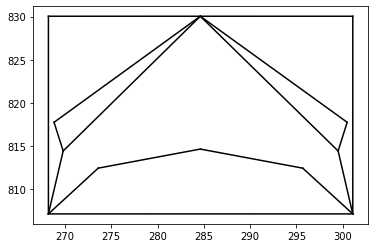

In [166]:
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

def convex_hull_polygon(points):
    hull = ConvexHull(points)
    chull = Polygon()

    for simplex in hull.simplices:
        x = points[simplex, 0]
        y = points[simplex, 1]

        # print(p0, p1)
        s = Segment(x[0], y[0], x[1], y[1])
        chull.add_segment(s)

    return chull

def create_rectangle(xmin, xmax, ymin, ymax):
    s1 = Segment(xmin, ymin, xmin, ymax)
    s2 = Segment(xmin, ymax, xmax, ymax)
    s3 = Segment(xmax, ymax, xmax, ymin)
    s4 = Segment(xmax, ymin, xmin, ymin)

    ret = Polygon()
    ret.add_segment(s1)
    ret.add_segment(s2)
    ret.add_segment(s3)
    ret.add_segment(s4)

    return ret


points = np.array(piece.to_points())
chull = convex_hull_polygon(points)

# plt.plot(points[:,0], points[:,1], 'o-')


min_ret = {
    'area': np.Inf,
    'theta': None,
    'ret': None,
    'convex_hull': None
}



for segment in chull.segments:
    # segment = chull.segments[2]
    theta = segment.x_angle()

    chull_rotated = chull.rotate(-theta, (0,0,))
    chull_points = np.array(chull_rotated.to_points())

    xs = chull_points[:, 0]
    ys = chull_points[:, 1]

    xmin = np.min(xs)
    xmax = np.max(xs)
    ymin = np.min(ys)
    ymax = np.max(ys)

    ret_area = (ymax - ymin) * (xmax - xmin)
    ret = create_rectangle(xmin, xmax, ymin, ymax)

    # chull_rotated.plot()
    # ret.plot()
    # piece.rotate(-0, (0,0,)).plot()

    if ret_area < min_ret['area']:
        min_ret['theta'] = theta
        min_ret['ret'] = ret
        min_ret['area'] = ret_area
        min_ret['convex_hull'] = chull_rotated

piece.plot()
min_ret['ret'].rotate(min_ret['theta'], (0,0,)).plot()


# # Rotate to be paralle to x axis
# deltaX = p1[0] - p0[0]
# deltaY = p1[1] - p0[1]
# theta = np.arctan(deltaY/deltaX)



# plt.plot(points[simplex, 0], points[simplex, 1], 'r-')
# chull.plot()



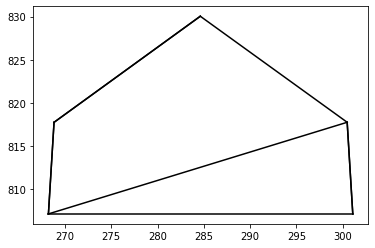

In [139]:
chull_rotated.plot()

plt.plot(x[0], x[1], '-')

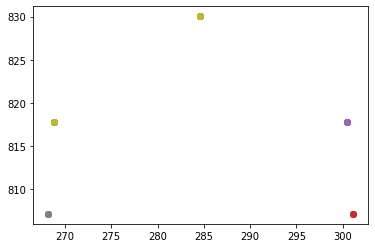

In [143]:
for segment in chull_rotated.segments:
    plt.plot(np.array([segment.x0, segment.x1]), np.array([segment.y0, segment.y1]), 'o')

In [61]:
point

array([284.61591313, 830.04106049])

In [65]:
np.array([(1,2,)])

array([[1, 2]])